In [1]:
#  Import libraries
from __future__ import print_function, absolute_import, division, unicode_literals

import numpy as np
import glob, os, sys
import fileinput
from astropy.io import fits
import matplotlib.pyplot as plt

from astropy.stats import sigma_clip
from datetime import datetime

# Bias Frames

In [2]:
cd DATA

C:\Users\Adiputra\siuling\UCSC\136\DATA


In [3]:
files_bias = [f for f in os.listdir('BIAS') if f.endswith('.fits')]


In [4]:
cd BIAS

C:\Users\Adiputra\siuling\UCSC\136\DATA\BIAS


In [5]:
vertical, horizontal = fits.open(files_bias[0])[0].data.shape
biasdata = np.zeros((vertical,horizontal,len(files_bias)))

for i in range(len(files_bias)):
    hdu = fits.open(files_bias[i])
    if not hdu[0].header['EXPTIME']:
        biasdata[:,:, i] = hdu[0].data

Find stats of bias

In [6]:
bias_mean = np.mean(biasdata, axis=2, keepdims=True)
bias_median = np.median(biasdata, axis=2, keepdims=True)
bias_std = np.std(biasdata, axis=2, keepdims=True)

Sigma clip bias data

In [7]:
biasdata_clipped = sigma_clip(biasdata)

#### Create Master Bias

In [8]:
master_bias = np.mean(biasdata_clipped, axis=2)

In [9]:
master_bias

masked_array(
  data=[[125.46666666666667, 125.70588235294117, 125.93333333333334, ...,
         107.10526315789474, 107.10526315789474, 106.10526315789474],
        [124.0625, 125.58823529411765, 123.33333333333333, ...,
         103.36842105263158, 103.47368421052632, 105.0],
        [123.93333333333334, 123.85714285714286, 123.11111111111111, ...,
         103.78947368421052, 107.10526315789474, 103.63157894736842],
        ...,
        [125.07142857142857, 122.84615384615384, 126.41176470588235, ...,
         106.42105263157895, 104.6842105263158, 105.78947368421052],
        [125.17647058823529, 126.25, 125.1875, ..., 108.84210526315789,
         105.6842105263158, 109.57894736842105],
        [126.8125, 126.47058823529412, 124.0, ..., 108.0,
         105.21052631578948, 109.78947368421052]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
       

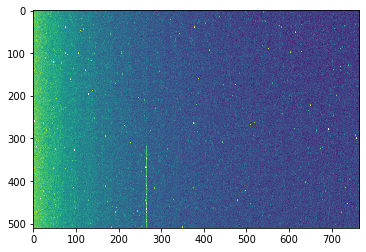

In [10]:
plt.imshow(master_bias)

# Dark Files

In [11]:
pwd

'C:\\Users\\Adiputra\\siuling\\UCSC\\136\\DATA\\BIAS'

In [12]:
cd ..

C:\Users\Adiputra\siuling\UCSC\136\DATA


In [13]:
files_dark = [f for f in os.listdir('DARK') if f.endswith('.fits')]


In [14]:
cd DARK

C:\Users\Adiputra\siuling\UCSC\136\DATA\DARK


In [15]:
vertical, horizontal = fits.open(files_dark[0])[0].data.shape
darkdata = np.zeros((vertical,horizontal,len(files_dark)))

In [16]:
for i in range(len(files_dark)):
    hdu = fits.open(files_dark[i])
    if hdu[0].header['EXPTIME'] > 0:
        correct_dark = (hdu[0].data - master_bias)/hdu[0].header['EXPTIME']
        darkdata[:,:, i] = correct_dark

In [17]:
#plt.imshow(fits.open(files_dark[0])[0].data)    #raw dark data
#darkdata.shape
#plt.imshow(darkdata[:,:,0])   #Corrected dark data


Find stats for darks

In [18]:
dark_mean = np.mean(darkdata, axis=2, keepdims=True)
dark_median = np.median(darkdata, axis=2, keepdims=True)
dark_std = np.std(darkdata, axis=2, keepdims=True)

Sigma clip dark data

In [19]:
darkdata_clipped = sigma_clip(darkdata)

### Create master dark

In [20]:
master_dark = np.mean(darkdata_clipped, axis=2)

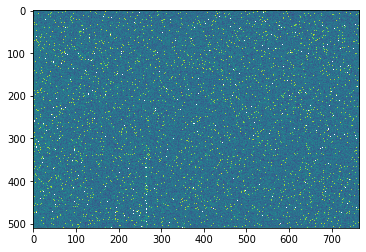

In [21]:
plt.imshow(master_dark)

# Flat Frames

In [22]:
cd ..

C:\Users\Adiputra\siuling\UCSC\136\DATA


In [23]:
files_flat = [f for f in os.listdir('FLAT') if f.endswith('.fits')]

In [24]:
cd FLAT

C:\Users\Adiputra\siuling\UCSC\136\DATA\FLAT


In [25]:
vertical, horizontal = fits.open(files_flat[0])[0].data.shape
flatdata = np.zeros((vertical,horizontal,len(files_flat)))

In [26]:
for i in range(len(files_flat)):
    hdu = fits.open(files_flat[i])
    if hdu[0].header['EXPTIME'] > 0:
        if hdu[0].header['APTDIA'] > 0:
            correct_flat = (((hdu[0].data - master_bias)/hdu[0].header['EXPTIME']) - master_dark)
            flatdata[:,:, i] = correct_flat

In [27]:
flatdata_clipped = sigma_clip(flatdata)

Normalize the flats by dividing by the minimum:

# Things I may use to find the minimum:
enumerate(flat_filtered_data)
min(flat_filtered_data[0,4,:])
ver, hor, filenum = flat_filtered_data.shape
flat_min = np.zeros((ver,hor,1))
for row, col, i in flat_filtered_data:
    min(flat_filtered_data[row,col,:])
flat_min.shape should be (510,765,1)

In [29]:
flat_norm = flatdata #/ flat_min #normalization

I think the statistics should be done after normalizing... but maybe it doesn't matter

In [30]:
flat_mean = np.mean(flatdata, axis=2, keepdims=True)
flat_median = np.median(flatdata, axis=2, keepdims=True)
flat_std = np.std(flatdata, axis=2, keepdims=True)

### Create Master Flat

In [31]:
master_flat = np.mean(flatdata_clipped, axis=2)

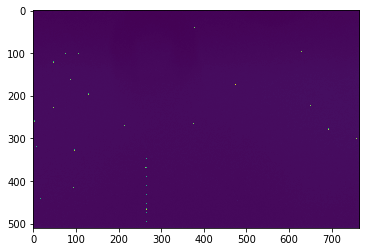

In [32]:
plt.imshow(master_flat)

# Science Frames

In [33]:
cd ..

C:\Users\Adiputra\siuling\UCSC\136\DATA


In [34]:
files_sci = [f for f in os.listdir('TWI_SKY') if f.endswith('.fits')]

In [35]:
cd TWI_SKY

C:\Users\Adiputra\siuling\UCSC\136\DATA\TWI_SKY


In [36]:
vertical, horizontal = fits.open(files_sci[0])[0].data.shape
scidata = np.zeros((vertical,horizontal,len(files_sci)))
obs_t_sci = []

In [37]:
for i in range(len(files_sci)):
    hdu_sci = fits.open(files_sci[i])
    header_sci = hdu_sci[0].header
    if header_sci['EXPTIME'] > 0:
        if header_sci['APTDIA'] > 0:
            correct_sci = (((hdu_sci[0].data - master_bias) /
                             header_sci['EXPTIME']) - master_dark
                             ) / master_flat
            scidata[:,:, i] = correct_sci
            
            time = header_sci['TIME-OBS']
            obs_t_sci += [time]   #or append. Just don't split to keep it as string

In [38]:
obs_t_sci[0]

'02:55:13.195'

In [39]:
scidata_clipped = sigma_clip(scidata)

### Calculate Stats

In [40]:
sci_mean = []
sci_median = []
sci_std = []

In [41]:
for i in range(scidata_clipped.shape[2]):
    mean = np.mean(scidata_clipped[:,:,i])
    median = np.median(scidata_clipped[:,:,i])
    std = np.std(scidata_clipped[:,:,i])
    
    sci_mean.append(mean)
    sci_median.append(median)
    sci_std.append(std)

C:\Users\Adiputra\Software\Anaconda3-2020.02\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


### Change OBS-TIME to secs

In [42]:
seconds = []
for i in range(len(obs_t_sci)):
    dt = datetime.strptime(obs_t_sci[i], '%H:%M:%S.%f')
    total_seconds = dt.second + dt.minute*60 + dt.hour*3600
    seconds.append(total_seconds)


print(seconds)

[10513, 10516, 10519, 10522, 10526, 10529, 10532, 10535, 10538, 10542, 10702, 10706, 10710, 10714, 10718, 10723, 10727, 10731, 10735, 10739, 10873, 10878, 10884, 10889, 10895, 10900, 10906, 10911, 10917, 10922, 11088, 11096, 11103, 11111, 11118, 11126, 11133, 11141, 11148, 11156, 11273, 11285, 11298, 11310, 11323, 11335, 11348, 11360, 11373, 11385, 11415, 11437, 11460, 11482, 11505, 11527, 11550, 11572, 11595, 11617, 11677, 11740, 11802, 11865, 11927, 12039, 12222]


# Plot counts vs. time

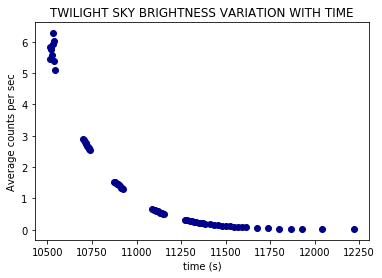

In [43]:
plt.xlabel('time (s)') 
plt.ylabel('Average counts per sec') 
plt.title('TWILIGHT SKY BRIGHTNESS VARIATION WITH TIME')
plt.scatter(seconds, sci_mean, label="projected" , color = 'darkblue')
plt.show()

### Linearize data

In [44]:
y = np.log(sci_mean)
m, b = np.polyfit(seconds, y, 1)

In [45]:
# Linear function:
def func(x,m,b):
    f = []
    for i in x:
        y = m*i + b
        f.append(y)
    return f

In [46]:
y_fit = func(seconds,m,b)

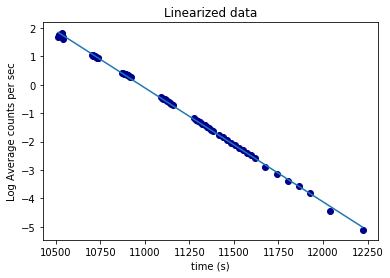

In [47]:
plt.xlabel('time (s)') 
plt.ylabel('Log Average counts per sec') 
plt.title('Linearized data')
plt.scatter(seconds, y, label="projected" , color = 'darkblue')
plt.plot(seconds, y_fit)
plt.savefig("Pau-Sanchez_Sky_Bri.pdf")


### Fit a line

In [48]:
dpsi_dt = m/(-6.1*)

SyntaxError: invalid syntax (<ipython-input-48-e3cf5c1d3585>, line 1)